<img align="center" style='max-width: 1000px' src="images/banner.png">

<img align="left" style='max-width: 150px; height: auto' src="images/hsg_logo.png">

# Lab 01 - "Meta-Learning"


## Objective

After this tutorial, you should be able to meta-train a model to learn an intialization that can be used to quickly adapt to novel tasks from a family of tasks.

**We will compare to different approaches:**

    - Supervised pre-training: pretrain a model on a family of tasks in a supervsied manner.
    - MAML: meta-train a model a model on a family of task using the MAML method.
 

## Outline

1. **Tensor Operations in PyTorch**: Under the hood of tensor operations in PyTorch.
2. **Stateful vs. Stateless Models**: How to execute models in stateful or stateless ways.
3. **Task Distribution**: Sine waves task distribution.
4. **Model Architecture**: Model architecture definition.
5. **Supervised Pre-training**: Pretaining in a supervised manner.
6. **MAML**: Meta-training with MAML.
7. **Model Adaptation**: Testing both approaches.


### Install Required Packages

In [90]:
# !pip install 'torch>=1.2*'

In [91]:
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import torch
import torch.nn as nn

## <font color='red'>1. Tensor Operations in PyTorch</font>

In this part, we will see:
- How does the computational graph of a model work in the background in PyTorch?
- What happens when we call `.backward()` on a (scalar) tensor?


### 1.1 Computational Graphs

PyTorch creates computational graphs **dynamically** on the fly.


$(x_1 \times x_2)' = x_1' \times x_2 + x_1\times x_2'$ <br>

After running the following tensor operations, PyTorch dynamically creates a computational graph in the background:

In [92]:
# Create random tensors x1 and x2 
x1 = torch.rand(1, 5, requires_grad=True)
x2 = torch.rand(1, 5, requires_grad=True)

a = x1 * x2

y1 = torch.log(a)
y2 = torch.sin(x2)

w = y1 * y2

L = torch.sum(w)

<img align="center" width="700" src="images/computational_graph_single.png">

As we can see, the `requires_grad` option for two tensor is set to `True` for tensor `x1` and `x2`. By doing so, after calling `backward()`, gradient values for those two tensors are calculated. Before calling `.backward()` on `L`, the gradient values for those two tensors are `Null`:


In [93]:
# Initially the gradients of x1 and x2 are None
print(x1.grad)
print(x2.grad)

None
None


Now, the more important question is: what happens under the hood, when we call `.backward()` on the loss tensor `L`?

The visualization below shows that after calling the backpropagation function PyTorch creates another graph for the computation of the gradients. The green graph is called "Gradient Graph" of the model which is automatically constructued by calling `L.backward()`:


<img align='center' style='max-width: 700px' src='images/computational_graph.gif'>

Let's call backward on `L` now:

In [94]:
L.backward()

After calling backward, we should be able to access the gradients of the tensors with `requires_grad=True`:

In [95]:
# Print the gradients of x1 and x2
print(x1.grad)
print(x2.grad)

tensor([[11.1711,  1.5974,  0.5980,  7.9425,  0.1781]])
tensor([[-1.7880, -0.2134, -1.5264, -0.4045, -0.7790]])


A second back-propagation through the model is not possible because after calling `backward()` the computational graph is freed. </br>
Soltion: set `retain_graph=True` once calling `.backward(...)` </br>
Every time we call backward, the gradients are accumulated.


In [96]:
# L.backward()

### 1.2 Computing gradients for particular variables directly without `.backward()`

In [97]:
# Given the same operations

x1 = torch.rand(1, 5, requires_grad=True)
x2 = torch.rand(1, 5, requires_grad=True)

a = x1 * x2

y1 = torch.log(a)
y2 = torch.sin(x2)

w = y1 * y2

L = torch.sum(w)


Now, we only want to compute $\frac{\partial L}{\partial x_1}$ :<br>
We use `torch.autograd.grad` to compute the gradients of a term w.r.t. a given set of variables. <br>
Unlike `.backward()`, it does not assign gradients to the graph nodes automatically.

In [98]:
# Compute gradient of L w.r.t. x1
g_x1 = torch.autograd.grad(L, x1, retain_graph=True)  # we keep the graph of the model to use it later 
 
print(g_x1)

(tensor([[1.4109, 0.3192, 1.1626, 0.6709, 1.6887]]),)


In [99]:
print(x1.grad)

None


In [100]:
# Now we compute the gradient of the model for later use
g_x2 = torch.autograd.grad(L, x2, retain_graph=True)  # we keep the graph of the model to use it later 

print(g_x2)

(tensor([[-2.8206, -0.1950, -1.3620,  0.0495, -0.3653]]),)


More about PyTorch's `autograd`:

https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/

## <font color='red'>2. Stateful vs. Stateless Models</font>

### 2.1 Stateful Models 
In stateful models, the model's weights are defined inside the model's class:

In [101]:
class StatefulMLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Model layers
        self.linear1 = nn.Linear(10, 5)
        self.linear2 = nn.Linear(5, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Forward steps
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

By creating and instance of the model we can just feed an input to it and get the out:

In [102]:
# Create and instance of the model
model_stateful = StatefulMLP()

# Create random tensor
x = torch.randn(8, 10)

# Make perdiction with the model using only x
out = model_stateful(x)

print(out)

tensor([[0.4065],
        [0.6403],
        [0.4558],
        [0.4998],
        [0.5035],
        [0.9927],
        [0.4875],
        [0.5859]], grad_fn=<AddmmBackward0>)


### 2.2 Stateless Models


Stateful models are ideal for most use cases, however, we may need stateless execution for some cases, for example:

- When the weights of the model are generated by another networks (Hyper-Networks)
- When we want to backpropagate through an optimization trajectory

<img align="center" width="900" src="images/stateless_applications.png">


In stateless model defnitions, the model's weights are not stored inside the model. Instead, they are provided through the forward function.

The forward function of the model needs to handle operations directly:

In [103]:
import torch.nn.functional as F

class StatelessMLP(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, params):
        # The forward function is defined in a different way
        # The model weights (parmeters) are given as an input to the forward function
        # We assume the model weights are given as a dictionary
        # Now we use PyTorch functionals to execute the graph operations
        x = F.linear(x, params["w1"])
        x = F.relu(x)
        x = F.linear(x, params["w2"])

        return x

PyTorch functionals: https://pytorch.org/docs/stable/nn.functional.html


How do functionals works? </br>
Example:
we can use `torch.nn.functional.linear` to apply a linear transformation, i.e: $x.w^T$

In [104]:
# Input: 8 x 10
# Transformation: 10 x 5
# Output: 8 x 5

# Input
x = torch.randn(8, 10)

# Weights
w = torch.ones(5, 10)

# Functional
out = F.linear(x, w)
print("Output shape is: ", out.shape)

Output shape is:  torch.Size([8, 5])


How to use a statelss model defintion?


In [105]:
# Define model
model_stateless  = StatelessMLP()

# Model input
x = torch.randn(8, 10)

# Model parameters (weights)
params = {
    "w1": torch.randn(5, 10),
    "w2": torch.randn(1, 5)
}

# Make prediction
out = model_stateless(x, params)

print(out.shape)

torch.Size([8, 1])


### 2.3  The Easier Way for Stateless Model Execution

- Defining model operations manually can be cumbersome for large models
- Given a regular pytorch model, we want to define a stateless model without re-defining the forwrad function

In PyTorch `1.12`, a new function was added for this purpose 

In [106]:
from torch.nn.utils.stateless import functional_call

In [107]:
# Using the previously defined StatefulMLP 
model1 = StatefulMLP()
model2 = StatefulMLP()

# create random tensor
x = torch.randn(8, 10)

# Use the weights of model2 to make prediction
params = dict(model2.named_parameters())
print(params.keys())

# Make prediction in a stateless way
pred = functional_call(model1, params, x)
print(pred.shape)


dict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])
torch.Size([8, 1])


/Users/hamed/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


### 2.4 Manually Assigning Gradients to a Model

When we call `loss.backward()`, PyTorch automatically computes gradients and assigns them to the model's parameters. </br>
However, when the gradients are calculated via `torch.autograd.grad()`, we need to assign them manually.

In [108]:
# Using the previously defined StatefulMLP 
model = StatefulMLP()

# Zero all gradients
model.zero_grad() 

# create random tensor
x = torch.randn(8, 10)

# Forward propagation
pred = model(x)

# Compute loss and gradients
loss = torch.mean(pred)
grads = torch.autograd.grad(loss, model.parameters())

In [109]:
print("Gradients before assignment")
for p in model.parameters():
    print(p.grad)

# Assign the gradients to the model's parameters
for (p, g) in zip(model.parameters(), grads):
    p.grad = g
    

print("\nGradients after assignment")
for p in model.parameters():
    print(p.grad)
    

Gradients before assignment
None
None
None
None

Gradients after assignment
tensor([[ 0.1925, -0.0286,  0.1822, -0.3537,  0.0018,  0.1692,  0.0165, -0.1475,
         -0.1295,  0.2802],
        [ 0.0109,  0.0134,  0.0066, -0.0193,  0.0028,  0.0390,  0.0026,  0.0030,
         -0.0127,  0.0270],
        [-0.0007,  0.0218,  0.0041, -0.0993,  0.0041,  0.1667, -0.0027,  0.0107,
         -0.1380,  0.2516],
        [-0.0393,  0.0544, -0.2098,  0.2796,  0.0265, -0.0776,  0.0051,  0.1155,
         -0.0354, -0.0590],
        [-0.0673,  0.0569,  0.0446, -0.0525,  0.0108,  0.1116, -0.0522,  0.0281,
          0.0410,  0.0595]])
tensor([ 0.2871,  0.0236,  0.1283, -0.2050,  0.0805])
tensor([[0.5169, 0.0942, 0.1602, 0.5623, 0.1860]])
tensor([1.])


Now, we are familiar with all tools and techniques to implement and train a meta-model :)

## <font color='red'>3. Task Distribution</font>

In this tutorial we want to learn an initialization from a distribution of sine waves. Therefore, we first need implement the task distribution class from which we can sample tasks.


Each task in this distribution is a regression problem with an underyling sine function. The sine function can change by setting it phase and amplitude: $y = amplitude \times \sin(phase + x)$

<img align="center" width="500" src="images/example_sine_wave.png">


### 3.1 Sine Waves Task Distribution: Class Definition

First, we define a class that generates random Sine Wave regression tasks:


In [110]:
# Code adapted from https://github.com/vmikulik/maml-pytorch

class SineTask():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax
        
    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        
        return self.amplitude * np.sin(self.phase + x)
        
    def sample_data(self, size=1):
        """
        Sample data from this task.
        
        returns: 
            x: the feature vector of length size
            y: the target vector of length size
        """
        
        x = np.random.uniform(self.xmin, self.xmax, size)
        y = self.true_function(x)
        
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float).unsqueeze(1)
        
        return x, y

class SineTaskDistribution():
    """
    The task distribution for sine regression tasks for MAML
    """
    
    def __init__(self, amplitude_min, amplitude_max, phase_min, phase_max, x_min, x_max):
        self.amplitude_min = amplitude_min
        self.amplitude_max = amplitude_max
        self.phase_min = phase_min
        self.phase_max = phase_max
        self.x_min = x_min
        self.x_max = x_max
        
    def sample_task(self):
        """
        Sample from the task distribution.
        
        returns:
            Sine_Task object
        """
        amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
        phase = np.random.uniform(self.phase_min, self.phase_max)
        return SineTask(amplitude, phase, self.x_min, self.x_max)

def plot_task(task, linestyle="solid", color="blue"):
    """ Plots the ground-truth sine function with its
    sampled datapoints.
    """
    # Plot ground-truth sine function
    gt_x = np.linspace(task.xmin, task.xmax, 1000)
    gt_y = task.amplitude * np.sin(gt_x + task.phase)
    plt.plot(gt_x, gt_y, c='black', linestyle=linestyle)
    plt.ylim([-5, 5])
    
    # Plot randomly sampled datapoints
    x, y = task.sample_data(10)
    plt.scatter(x.numpy().reshape(-1), y.numpy().reshape(-1), c=color)

### 3.1 Visualizing Randomly Sampled Tasks

Now, we initialize the `SineTaskDistribution` with predefined parameter ranges. For example we set the range of possible amplitude to [0.1, 5.0], and the range of possible phases to [0.0, $\pi$].

In [111]:
# Define task distribution for the given parameters
task_dist = SineTaskDistribution(
    amplitude_min=0.1, 
    amplitude_max=5,
    phase_min=0, 
    phase_max=np.pi, 
    x_min=-5, 
    x_max=5
)

Now, let's generate some random tasks and plot them:

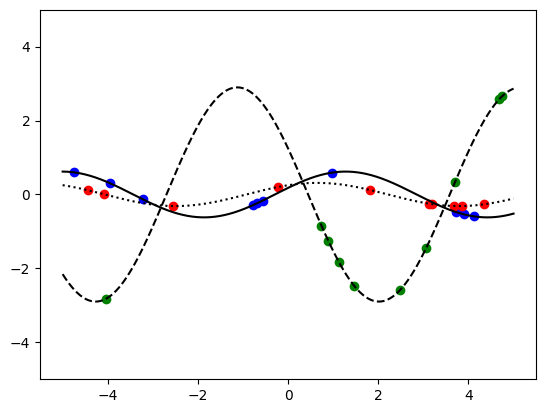

In [112]:

# Sample a random task and plot it
task = task_dist.sample_task()
plot_task(task, linestyle="solid", color="blue")

# Another random task
task = task_dist.sample_task()
plot_task(task, linestyle="dashed", color="green")

# Another random task
task = task_dist.sample_task()
plot_task(task, linestyle="dotted", color="red")


## <font color='red'>4. Model Architecture</font>

We use a simple MLP with one hidden layer for this regression task:

In [113]:
class MLP(nn.Module):
    """ Defnition of Sine wave estimator model."""
    def __init__(self):
        super().__init__()
        
        # Model layers
        self.layers = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
  
    def forward(self, x):
        return self.layers(x)


## <font color='red'>5. Approach 1: Supervised Pre-training </font>
In supervised pre-training, we sample a task in each step. Then, we train the sampled model for some steps. The "converged" model from the previous task is used for training on the next task. 


<img align='center' style='max-width: 1200px' src='images/supervised_pretraining.gif'>

In [114]:
def train_task_supervised(task, model, criterion, optimizer, device=torch.device("cpu")):
    # Extract datapoints and convert to compute device
    x, y = task.sample_data(10)
    x, y = x.to(device), y.to(device)

    # Reset model gradients
    model.zero_grad()

    # Make prediction and compute loss
    pred = model(x)
    loss = criterion(pred, y)

    # Compute gradients and update model
    loss.backward()
    optimizer.step()

    return loss
        
def pretrained_supervised(n_iterations=1000, device=torch.device("cpu")):
    """ Pretrains a model on a distribution of tasks in a supervised manner.
    
        n_iterations: number of iterations.
    """
    # Define model, optimizer and criterion
    model = MLP()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # Progress bar
    progress = tqdm.tqdm(range(n_iterations))
    
    # List to store losses
    losses = []
    
    for itr in progress:
        # Sample a task
        task = task_dist.sample_task()

        loss = train_task_supervised(task, model, criterion, optimizer, device)
        
        # Log loss value
        if itr % 10 == 0:
            losses.append(loss.item())

        progress.set_description(f"Loss: {loss.item():0.4f}")
        progress.update()

    # Plot loss curve
    plt.plot(list(range(len(losses))), losses)  
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    return model

Loss: 5.4085: 100%|██████████| 10000/10000 [00:09<00:00, 1094.14it/s]


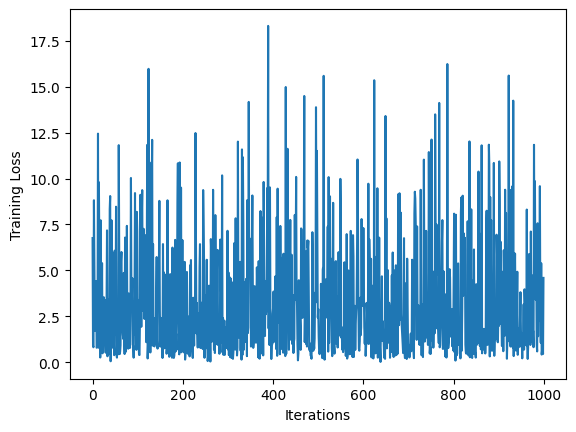

In [115]:
model_pretrained = pretrained_supervised(n_iterations=10000)

## <font color='red'>6. Approach 2: MAML</font>

<img align="center" width="300" src="images/maml.png">

###### Image source, and more about MAML: https://bair.berkeley.edu/blog/2017/07/18/learning-to-learn/



In MAML, instead of immediately updating the model (meta-model) in eack task, we "simulate" the optimization steps for a set of tasks to obtain gradients from each task separately. Then, we use the obtained gradients from all tasks to compute the meta-gradient (by averaging them) and update the meta-model.




<img align='center' style='max-width: 1200px' src='images/meta_learning.gif'>

One the meta-gradient is calcualted, we manually assing the meta-gradient to the meta-model with the following function:

In [116]:
def apply_grad(params, grad):
    for p, g in zip(params, grad):
        p.grad = g

In the inner loop, we try to "simulate" the optimization steps of a particular task to "assess" how the meta-model performs by training it on the current task after only few SGD steps and few samples:

In [117]:
def inner_loop(task, model, criterion, device):
    """ Implements the inner loop of a meta-learning task.
        The inner loop "simulates" one task.
    """
    params_initial = deepcopy(dict(model.named_parameters()))
    lr_inner = 0.01

    # Sample data for meta-train train-set
    x_train, y_train = task.sample_data(10)
    x_train, y_train = x_train.to(device), y_train.to(device)

    # Update model for one SGD step
    pred = functional_call(model, params_initial, x_train)
    loss = criterion(pred, y_train)
    grad = torch.autograd.grad(loss, params_initial.values(), retain_graph=True, create_graph=True)
    apply_grad(params_initial.values(), grad)
    params_updated = {
      n: p - lr_inner * g for ((n, p), g) in zip(params_initial.items(), grad)
    }

    # Use the updated parameters to compute meta-train test loss
    x_test, y_test = task.sample_data(10)
    x_test, y_test = x_test.to(device), y_test.to(device)
    pred_test = functional_call(model, params_updated, x_test)
    loss_test = criterion(pred_test, y_test)

    grad = torch.autograd.grad(loss_test, params_initial.values())

    return grad, loss_test


The main training loop for the meta-training procedure:

In [118]:
def meta_train_maml(n_iterations=1000, n_meta_tasks=10, device=torch.device("cpu")):
    """ Meta-trains a model on a distribution of tasks.
        n_iterations: number of iterations.
        n_meta_tasks: number of tasks in each iterations.
    """
    # Define model, optimizer and criterion
    model = MLP()
    model.to(device)
    criterion = nn.MSELoss()
    optimizer_meta = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Progress bar
    progress = tqdm.tqdm(list(range(n_iterations)))
    
    # List of meta-losses
    meta_losses = []
    
    # Iterate for n_iteration times
    for itr in progress:
        # Zero all gradients
        model.zero_grad()
        
        # List to store meta-gradients for tasks at step `itr`
        meta_batch_grads = []
        
        # List to store meta-gradients at step `itr`
        meta_batch_losses = []
        
        # Iterate for `n_meta_tasks` times
        for i in range(n_meta_tasks):
            # Sample a random task
            task = task_dist.sample_task()
            
            # Compute the gradient and loss in the inner loo
            grad, loss = inner_loop(task, model, criterion, device)

            meta_batch_grads.append(grad)
            meta_batch_losses.append(loss.item())
        
        # Compute the mean of gradients over the sampled tasks
        meta_loss = sum(meta_batch_losses) / len(meta_batch_losses)
        meta_grad = [sum(g) / len(g) for g in zip(*meta_batch_grads)]
        
        # Assign the meta-gradients to the meta-model
        apply_grad(model.parameters(), meta_grad)
        
        # Update meta-model
        optimizer_meta.step()
        
        # Log meta-loss
        if itr % 10 == 0:
            meta_losses.append(meta_loss)
        progress.set_description(f"Meta-loss: {meta_loss:0.2f}")
        progress.update()

    plt.plot(list(range(len(meta_losses))), meta_losses)
    plt.xlabel("Iterations")
    plt.ylabel("Meta-Training Loss")
    
    return model

Meta-loss: 0.19: 100%|██████████| 10000/10000 [01:05<00:00, 152.65it/s]


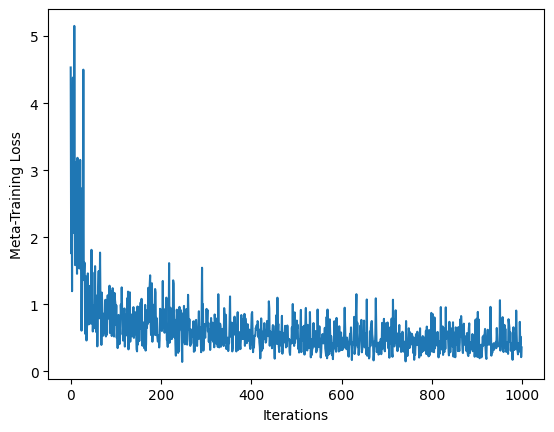

In [119]:
model_meta = meta_train_maml(n_iterations=10000, n_meta_tasks=10)

## <font color='red'>7. Model Adaptation: Testing Both Approaches</font> 

Once the model is trained, we test the model with a new sine wave task. 

First we adapt the model to the new task using very few samples and SGD steps, then we employ the adapted model for prediction on unseen samples of that task.

In [120]:
def adapt_model(model_original, x, y, n_steps=1):
    """ Adapts a model using samples (x, y) with n steps of SGD.
    
        model_original: trained model
        x, y: data samples
        n_steps: number of gradient descent steps
    """
    # Make a copy of the model to avoid changes to the original model
    model = deepcopy(model_original)
    
    # Set model train mode
    model.train()
    
    # Optimizer and criteiron for adaptation
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # Adapt the model for n steps
    for i in range(n_steps):
        model.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
    
    return model

For adaptation, we randomly sample a task from the task distribution and then randomly sample n data-points to adapt the model. <br>
The number of samples (n), determines the number of shots, therefore we say the problem is an *n-shot learning* problem.

In [121]:
device = torch.device("cpu")

# Sample a random task
task = task_dist.sample_task()

# Use few samples to adapt the model
x, y = task.sample_data(10)
x, y = x.to(device), y.to(device)

# Adapt the supervised pre-trained model and set eval mode on
model_pretrained_adapted = adapt_model(model_pretrained, x, y, n_steps=5)
model_pretrained_adapted.eval()

# Adapt the meta-model and set eval mode on
model_meta_adapted = adapt_model(model_meta, x, y, n_steps=5)
model_meta_adapted.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=1, bias=True)
  )
)

Finally, we plot the results for the adapted models. </br>


Text(0.5, 1.0, 'Meta-Model')

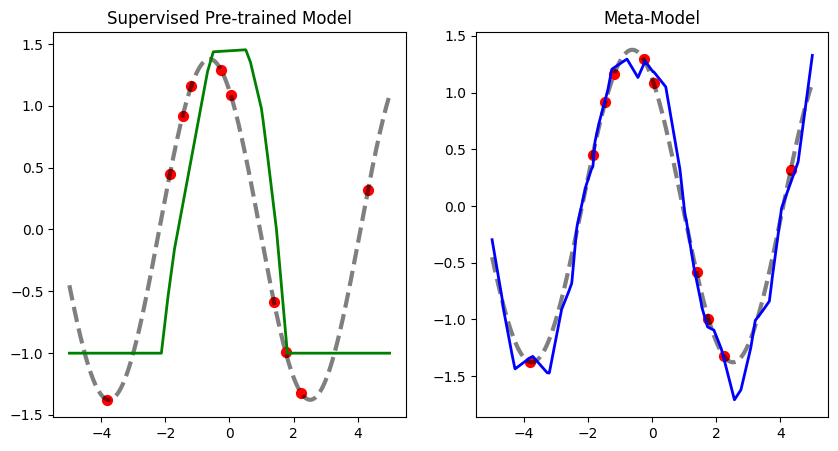

In [122]:
# ==============================> Plot results

# Create sub-plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# -----> Plot supervised-pretrained model results
# GT
gt_x = np.linspace(task.xmin, task.xmax, 1000)
gt_y = task.amplitude * np.sin(gt_x + task.phase)
ax[0].plot(gt_x, gt_y, c='black', linewidth=3.0, linestyle="dashed", alpha=0.5)
ax[0].scatter(x.cpu().numpy().reshape(-1), y.cpu().numpy().reshape(-1), c='red', s=50)

# Prediction
gt_x_tensor = torch.FloatTensor(gt_x).unsqueeze(1).to(device)
pred_pretrained = model_pretrained_adapted(gt_x_tensor).detach().cpu().squeeze().numpy()
ax[0].plot(gt_x, pred_pretrained, c='green', linewidth=2.0)
ax[0].set_title("Supervised Pre-trained Model")

# -----> Plot meta-model results

# GT
gt_x = np.linspace(task.xmin, task.xmax, 1000)
gt_y = task.amplitude * np.sin(gt_x + task.phase)
ax[1].plot(gt_x, gt_y, c='black', linewidth=3.0, linestyle="dashed", alpha=0.5)
ax[1].scatter(x.cpu().numpy().reshape(-1), y.cpu().numpy().reshape(-1), c='red', s=50)

# Prediction
gt_x_tensor = torch.FloatTensor(gt_x).unsqueeze(1).to(device)
pred_meta = model_meta_adapted(gt_x_tensor).detach().cpu().squeeze().numpy()
ax[1].plot(gt_x, pred_meta, c='blue', linewidth=2.0)

ax[1].set_title("Meta-Model")